In [1]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

import pickle

In [2]:
import csv
from scipy import sparse
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [3]:
train_preprocessed = pd.read_csv("train_preprocessed.csv")
test_preprocessed = pd.read_csv("test_preprocessed.csv")

In [4]:
train_preprocessed['label'].value_counts()

unrelated    175598
agreed        74238
disagreed      6606
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

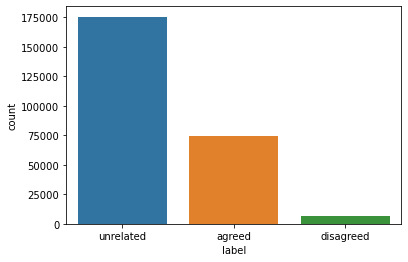

In [5]:
import seaborn as sns
sns.countplot(data=train_preprocessed, x="label")

In [6]:
train_preprocessed.shape

(256442, 4)

The training data is split into train and validation data in the ratio of 80:20. The training data to train the classifier and the validation data to evaluate the performance of the model.

In [7]:
train_ratio = 80/100
validation_ratio = 20/100

train_data, validation_data = np.split(train_preprocessed.sample(frac=1, random_state=100), 
                                       [int(train_ratio * train_preprocessed.shape[0])])

print(train_data.shape, validation_data.shape)

(205153, 4) (51289, 4)


In [8]:
train_data_labels = train_data['label']
validation_data_labels = validation_data['label']

# Feature Extraction

In [9]:
#create vocabulary
vectorizer = CountVectorizer()
feature = train_preprocessed["title1_en"] + train_preprocessed["title2_en"]
train_headline_counts = vectorizer.fit_transform(list(feature))
vocab = (list(vectorizer.vocabulary_.keys()))

vectorizer = CountVectorizer(vocabulary=vocab)
transformer = TfidfTransformer()

In [10]:
#Create features using TF - IDF for train data
#Title1
title_1 = train_data["title1_en"]

title1_counts = vectorizer.fit_transform(list(title_1))
title1_tfidf = transformer.fit_transform(title1_counts)

#Title 2
title_2 = train_data["title2_en"]

title2_counts = vectorizer.fit_transform(list(title_2))
title2_tfidf = transformer.fit_transform(title2_counts)

# Create a feature with two tfidf columns
train_feature_tfidf = sparse.hstack([title1_tfidf,title2_tfidf])

In [11]:
#Create features using TF - IDF for validation data
#Title1
title_1 = validation_data["title1_en"]

title1_counts = vectorizer.fit_transform(list(title_1))
title1_tfidf = transformer.fit_transform(title1_counts)

#Title 2
title_2 = validation_data["title2_en"]

title2_counts = vectorizer.fit_transform(list(title_2))
title2_tfidf = transformer.fit_transform(title2_counts)

# Create a feature with two tfidf columns
validation_feature_tfidf = sparse.hstack([title1_tfidf,title2_tfidf])

# Data Modeling

# Naive Bayes

In [12]:
mnb = MultinomialNB()
mnb.fit(train_feature_tfidf, train_data_labels) #fitting model using training data

MultinomialNB()

In [13]:
# Accuracy while using train data
mnb_preds = mnb.predict(train_feature_tfidf)
accuracy_score(mnb_preds,train_data_labels)

0.7898690245816536

In [14]:
# Accuracy while using validation data
mnb_preds = mnb.predict(validation_feature_tfidf)
accuracy_score(mnb_preds,validation_data_labels)

0.765719744974556

# Logistic Regression

In [15]:
lr = LogisticRegression(solver = 'saga',multi_class='multinomial')

In [16]:
lr.fit(train_feature_tfidf, train_data_labels) #fitting model using training data

LogisticRegression(multi_class='multinomial', solver='saga')

In [17]:
lr.score(train_feature_tfidf,train_data_labels) # Accuracy while using train data

0.8565802108670114

In [18]:
lr.score(validation_feature_tfidf,validation_data_labels) # Accuracy while using validation data

0.806118270974283

# Multi-Layer Perceptron Classifier

In [20]:
mlp= MLPClassifier(activation = "relu",
                    random_state=1, 
                    max_iter=20,
                    hidden_layer_sizes = (10),
                    verbose = True,
                    shuffle = True)

In [21]:
mlp.fit(train_feature_tfidf,train_data_labels) #fitting model using training data

Iteration 1, loss = 0.58180993
Iteration 2, loss = 0.40707128
Iteration 3, loss = 0.34780473
Iteration 4, loss = 0.31185501
Iteration 5, loss = 0.28574393
Iteration 6, loss = 0.26528996
Iteration 7, loss = 0.24871677
Iteration 8, loss = 0.23432301
Iteration 9, loss = 0.22229733
Iteration 10, loss = 0.21168403
Iteration 11, loss = 0.20290643
Iteration 12, loss = 0.19435946
Iteration 13, loss = 0.18667079
Iteration 14, loss = 0.18000529
Iteration 15, loss = 0.17378938
Iteration 16, loss = 0.16791868
Iteration 17, loss = 0.16270217
Iteration 18, loss = 0.15795803
Iteration 19, loss = 0.15323821
Iteration 20, loss = 0.14868059


C:\Users\Cathy\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=10, max_iter=20, random_state=1, verbose=True)

In [22]:
mlp.score(train_feature_tfidf,train_data_labels) # Accuracy while using train data

0.9554576340584832

In [23]:
mlp.score(validation_feature_tfidf,validation_data_labels) # Accuracy while using validation data

0.8131373198931545

In [ ]:
'''
mlp = MLPClassifier(activation = "relu",
                    random_state=1, 
                    max_iter=20,
                    solver = "adam",
                    learning_rate = "adaptive",
                    batch_size = 128,
                    hidden_layer_sizes = (100),
                    verbose = True,
                    shuffle = True)

mlp.fit(final_feature_tfidf,train_labels)
'''

# This model fitted the whole train_processed data and got an accuracy of 0.99823 and pickled into MLP_Model.sav
# as this really took a long time to train this classifier.

In [24]:
best_model_MLP = pickle.load(open("MLP_Model.sav", 'rb'))
train_preds = best_model_MLP.predict(train_feature_tfidf)
accuracy_score(train_preds,train_data_labels)

0.9982403376991806

In [25]:
validation_preds = best_model_MLP.predict(validation_feature_tfidf)
accuracy_score(validation_preds,validation_data_labels)

0.9982257404121742

# Testing - Model Prediction

In [26]:
#Create TF - IDF features for test data

#Title1
test_title_1 = test_preprocessed["title1_en"]

test_title1_counts = vectorizer.fit_transform(list(test_title_1))
test_title1_tfidf = transformer.fit_transform(test_title1_counts)

#Title 2
test_title_2 = test_preprocessed["title2_en"]

test_title2_counts = vectorizer.fit_transform(list(test_title_2))
test_title2_tfidf = transformer.fit_transform(test_title2_counts)

# Create a feature with two tfidf columns
final_feature_test = sparse.hstack([test_title1_tfidf,test_title2_tfidf])

In [ ]:
best_model_MLP = pickle.load(open("MLP_Model.sav", 'rb'))  #MLP model (hideen layer=100)
test_preds = best_model_MLP.predict(final_feature_test)

In [ ]:
test_id = test_preprocessed["id"]
submit = pd.DataFrame()
submit["id"] = test_id
submit["label"] = test_preds
submit.to_csv("submission.csv",index = False)

In [ ]:
submission = pd.read_csv("submission.csv")
submission['label'].value_counts()